**[Computer Vision Home Page](https://www.kaggle.com/ryanholbrook/computer-vision)**

---


<!-- Convolution and Pooling -->

# Introduction #

In the last lesson, we learned how the activations in the network represent features and how the weights defined filters. We saw how these features developed as the array of activations flowed through a convolutional block.

Convolution and pooling -- implemented in the layers of the network -- are what give a convnet its characteristic structure. Our goal in this lesson is to understand *why* this structure produces features favorable to solving the image classification problem. We want to understand why convolution and pooling are so good at visual feature extraction.

# Moving Windows #
 
Convolution and pooling both make use of a device called a **moving window**. You can think of a moving window as a box that scans over an image -- left to right, top to bottom -- summarizing pixel values along the way.

For one-dimensional data (like a sequence or time series), it looks like this:

<!--TODO: 1D moving window-->
<figure>
<img src="" width=400 alt="A 1D moving window.">
</figure>

For two-dimensional data (like images), it looks like this:

<!--TODO: 2D moving window-->
<figure>
<img src="" width=400 alt="A 2D moving window.">
</figure>

A moving window is the right sort of device to use for feature extraction because it makes use of the *position* of the pixels. A computation like the mean of all the pixel values would be less informative because it ignores location.

(In fact, their use of moving windows is one thing that makes convnets useful on other kinds of ordered data, like time series or natural language texts.)

For convolution, the "window size" is given by the dimensions of the kernel: a kernel with 3 rows and 3 columns gives a $3 \times 3$ window. For pooling, this is the dimension of the region it will summarize into a single pixel value: a maximum pooling layer with a pool size of `(2, 2)` will replace the 4 pixels in that window with the pixel with maximum value.

The moving window computation gives convolutional layers an advantage over dense layers, which also use positional information. In natural images, information tends to be highly *local*: groups of pixels close together will tend to contain more information than pixels far apart. This is what makes convolutional layers much more efficient than dense layers at feature extraction.

## Stride ##

The distance the window moves at each step is called the **stride**. Operations on two dimensional data will specify a stride in both dimensions: one for moving left to right and one for moving top to bottom.

<!--TODO: stride-->
<figure>
<img src="" width=400 alt="Stride.">
</figure>

A convolutional layer will usually use a stride of 1 so that the kernel is applied equally across the entire image. This tends to maximize the amount of information retained in the feature and generally gives the best results.

<!--TODO: convolution stride-->
<figure>
<img src="" width=400 alt="Convolution and stride.">
</figure>

A pooling layer will almost always have a stride greater than 1. This is what enables it to reduce the dimensions of its inputs. When the stride is the same as the window size, the input will be divided into distinct blocks. This maximum pooling with a `(2, 2)` window size and a `(2, 2)` stride.

<figure>
<!-- <img src="./images/4-pooling-blocks.png" width="800" alt="Pooling reduces the dimensions of feature maps."> -->
<img src="https://i.imgur.com/Nd3SlL3.png" width="400" alt="Pooling reduces the dimensions of feature maps.">
</figure>

Whenever the stride is greater than 1, the each dimension of the output will be reduced by that factor. For instance, a stride of 2 will reduce each dimension by a factor of 2, for a total reduction in pixels by a factor of 4. You can see in the above figure how pooling reduced a \(12 \times 12 \) image to a \(6 \times 6\) image. This is how the pooling layer is able to condense features.

# Example - Convolution #

Let's see what effect the convolution's kernel size has on the feature extracted. We'll start by defining some kernels of various dimesions. (You'll explore the stride in the exercises.) All of these kernels will be *vertical edge detectors*.

In [1]:
import visiontools
import numpy as np
import tensorflow as tf

def vertical_edge(kernel_size):
    kernel = np.zeros(kernel_size, dtype=int)
    kernel[:, 0] = 1
    kernel[:, -1] = -1
    return kernel

k33 = vertical_edge([3, 3])
k55 = vertical_edge([5, 5])
k77 = vertical_edge([7, 7])

Now let's take a look at the kernels and images we'll use:

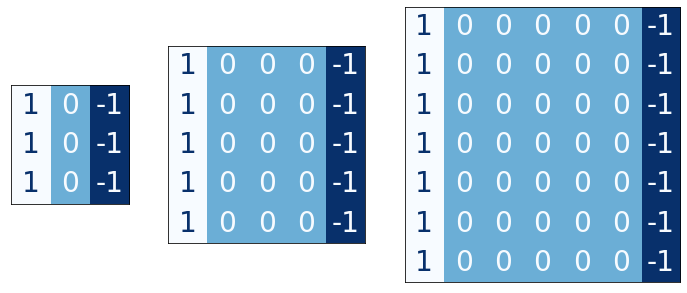

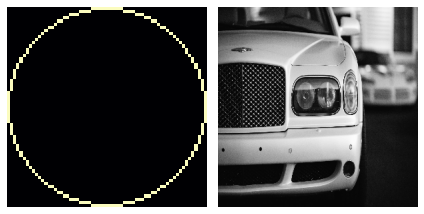

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage import draw, transform
import warnings
warnings.filterwarnings('ignore')

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

def read_image(path, channels=0):
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=channels)
    return image

plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 5, 7], wspace=0.2) 
for i, kernel in enumerate([k33, k55, k77]):
    plt.subplot(gs[i])
    visiontools.show_kernel(kernel)
plt.show();

SIZE = [64, 64]
circle = tf.reshape(visiontools.circle(SIZE, val=1.0), shape=[*SIZE, 1])

car = read_image('/kaggle/input/computer-vision-resources/car_illus.jpg', channels=1)
SIZE = [300, 300]
car = tf.image.resize(car, size=SIZE, preserve_aspect_ratio=False)

plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(circle))
plt.axis('off')
plt.subplot(122)
plt.imshow(tf.squeeze(car), cmap='gray')
plt.axis('off')
plt.show();

We'll loop over the list of kernels and use the `show_extraction` function (which you might remember from last lesson) to see the results.

Kernel shape: (3, 3)


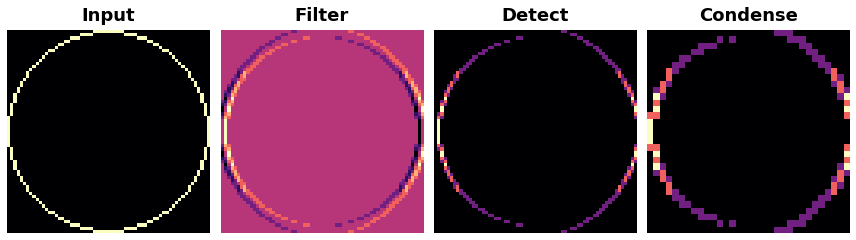

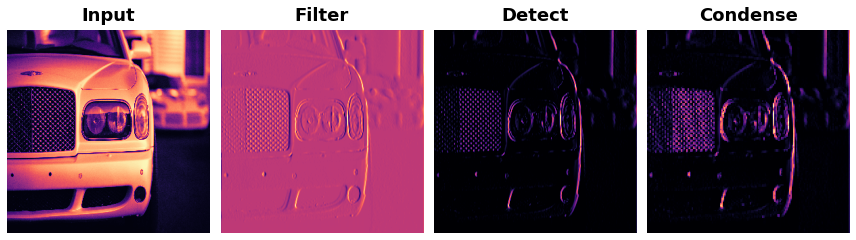

Kernel shape: (5, 5)


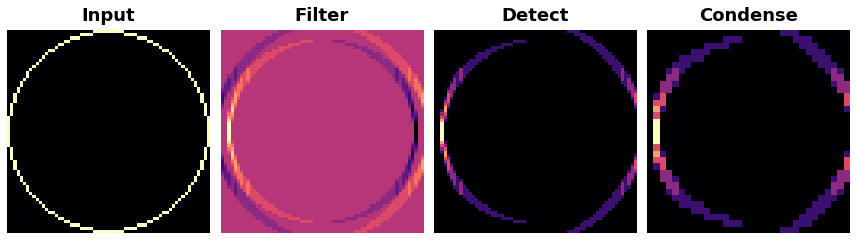

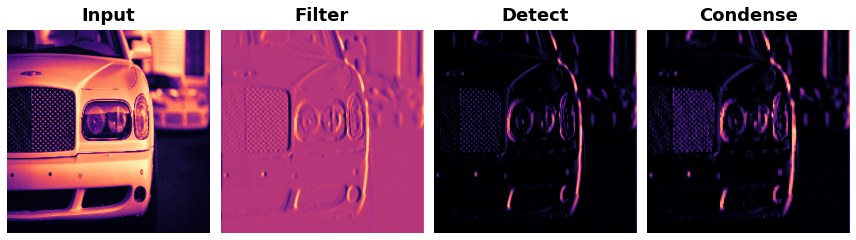

Kernel shape: (7, 7)


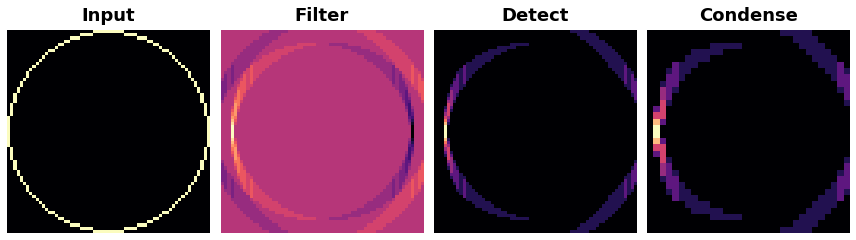

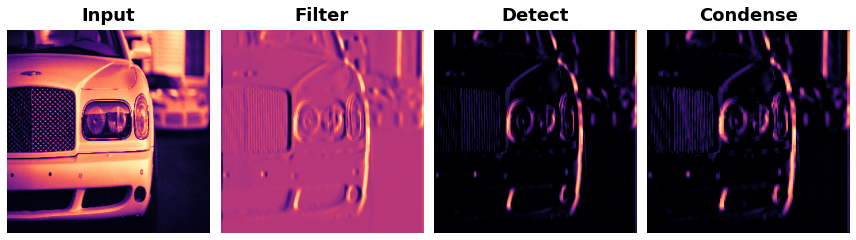

In [3]:
for kernel in [k33, k55, k77]:
    print("Kernel shape: {}".format(kernel.shape))
    visiontools.show_extraction(circle, kernel=kernel, subplot_shape=(1, 4), figsize=(12, 4))
    visiontools.show_extraction(car, kernel=kernel, subplot_shape=(1, 4), figsize=(12, 4))
    plt.show()

What do you see? As the convolutional window grows larger, finer details are lost while larger features are emphasized. It's not uncommon for convolutional networks to start with larger kernels for the first convolutional layer and drop to smaller kernels in additional layers (from $5 \times 5$ to $3 \times 3$, say).

# Example - Pooling #

Now let's take a look at the effect of stride with pooling. (You'll look at window size in the exercises.) We'll use the $3 \times 3$ kernel from the last example and a standard $2 \times 2$ pooling window as well. We'll iterate over strides with 1, 2, and 4 steps at a time.

Pooling Stride: (1, 1)


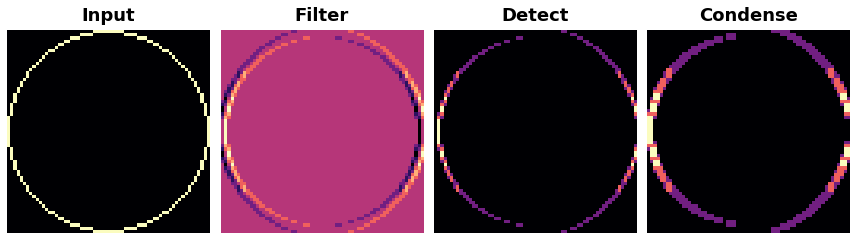

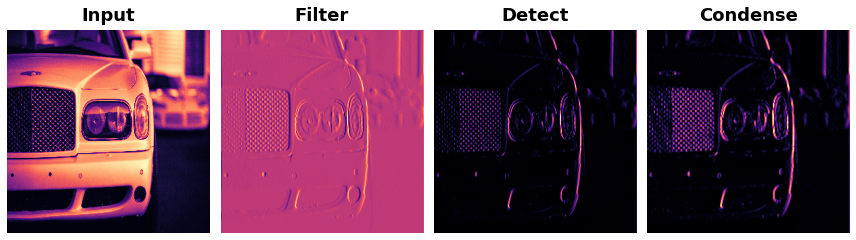

Pooling Stride: (2, 2)


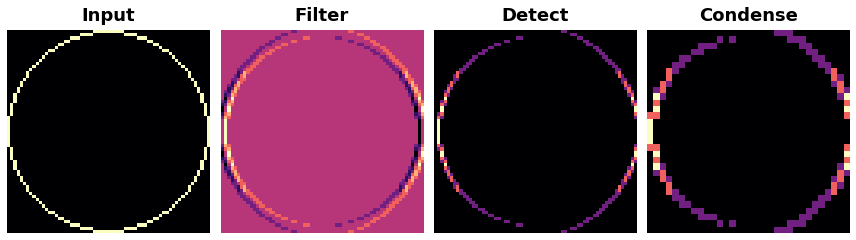

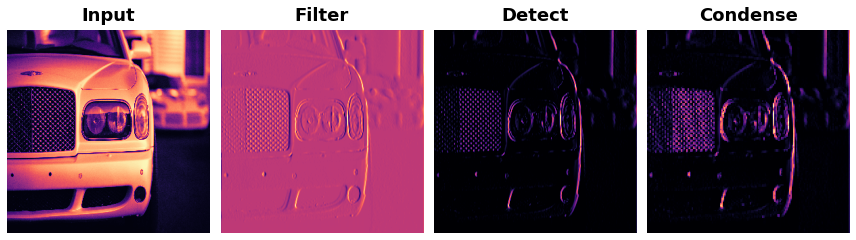

Pooling Stride: (4, 4)


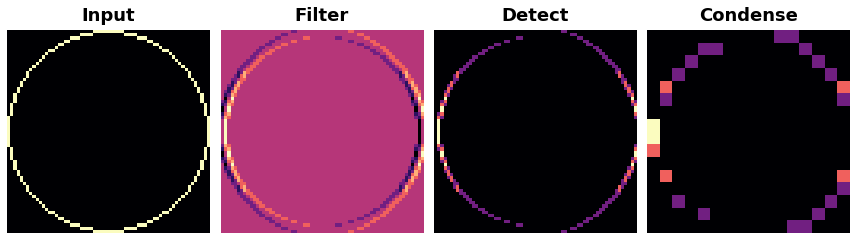

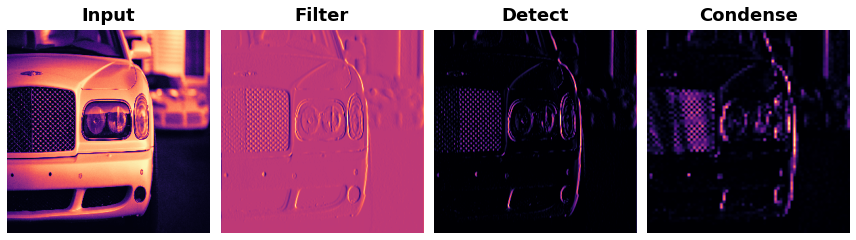

In [4]:
for stride in [(1, 1), (2, 2), (4, 4)]:
    print("Pooling Stride: {}".format(stride))
    visiontools.show_extraction(circle, kernel=k33, 
                                pool_stride=stride, pool_size=(2, 2),
                                subplot_shape=(1, 4), figsize=(12, 4))
    visiontools.show_extraction(car, kernel=k33,
                                pool_stride=stride, pool_size=(2, 2),
                                subplot_shape=(1, 4), figsize=(12, 4))
    plt.show()

Observe the difference in how the feature changes from the **Detect** stage to the **Condense** stage. With a $1 \times 1$ stride, the feature is emphasized, but there is no size reduction -- which is a waste of parameters! With the $4 \times 4$ kernel, there are "gaps" between the pooling windows and too much information seems to be lost. The standard method of setting the stride to be the same as the pooling window seems like the best bet!

# Translation Invariance #

The pooling operation gives a convnet a property called **translation invariance**. This just means that it tends not to distinguish features by their *location* in the image. ("Translation" is the mathematical word for changing the position of something without rotating it or changing its shape or size.)

<figure>
<!-- <img src="./images/.png" width="800" alt="."> -->
<img src="" alt="Translated features.">
</figure>

A convnet with translation invariance will treat these features the same. Why is that? Watch what happens when we repeatedly apply maximum pooling to the following feature maps.

<figure>
<!-- <img src="./images/4-two-dots.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://i.imgur.com/97j8WA1.png" width="800" alt="Pooling tends to destroy positional information.">
</figure>

The two dots in the original image became indistinguishable after repeated pooling. In other words, pooling destroyed some of their positional information. Since the network can no longer distinguish between them in the feature maps, it can't distinguish them in the original image either: it has become *invariant* to that difference in position.

In fact, pooling only creates translation invariance in a network *over small distances*, as with the two dots in the image. Features that begin far apart will remain distinct after pooling; only *some* of the positional information was lost, but not all of it.

<figure>
<!-- <img src="./images/4-two-dots-2.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://i.imgur.com/kUMWdcP.png" width="800" alt="But only over small distances. Two dots far apart stay separated">
</figure>


This invariance to small differences in the positions of features is a nice property for an image classifier to have. Just because of differences in perspective or framing, the same kind of feature might be positioned in various parts of the original image, but we would still like for the classifier to recognize that they are the same. Because this invariance is *built into* the network, we can get away with using much less data for training: we no longer have to teach it to ignore that difference. This gives convolutional networks a big effeciency advantage over a network with only dense layers. (You'll see another way to get invariance for free in **Lesson 8** with **Data Augmentation**!)



# Conclusion #

As we've seen over the last couple of lessons, when used together convolution and pooling are effective at extracting certain kinds of features from an image. These features, however, are too simple by themselves to be effective for use in the complex kinds of classification problems in demand today -- a network with only a single convolutional block would certainly not do well on our cars dataset! In the next lesson, you'll see how modern neural networks solve this problem by stacking deep layers of convolutional blocks. It is through many repetitions of this feature extraction process that a network can build the most informative features.

---
**[Computer Vision Home Page](https://www.kaggle.com/ryanholbrook/computer-vision)**





*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum) to chat with other Learners.*